# Miniproject Two:
## Authored by Hussein, Behnaz, and Arneet:


# IMDb Reviews Dataset:

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Download the IMDb Reviews dataset

In [ ]:
# Download the IMDb Reviews dataset
!rm -rf datalab
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!ls
!uncompress aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar
!rm aclImdb_v1.tar
!ls

### Import the necesseray modules:

In [16]:
# Importing the libraries
import time
import os 
import re
import string
import numpy as np 
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB as MN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Acquire and preprocess the data

In [17]:
# Importing train data
Train_Path = r'/content/aclImdb/train'   #Copy the path here
labels = {'pos': 1, 'neg': 0}
train_reviews=[]
train_labels=[]
for d in ('pos', 'neg'):
    path = os.path.join(Train_Path, d)
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
            txt = infile.read()
            train_reviews.append(txt)
            train_labels.append(labels[d])
# train data Permutation
inds = np.random.permutation(len(train_reviews))
train_reviews = np.array(train_reviews)[inds]
# train_reviews = train_reviews[inds]
train_labels=np.array(train_labels)[inds]
# train_labels = train_labels[inds]

# Importing test data
Test_Path = r'/content/aclImdb/test'  #Copy the path here
labels = {'pos': 1, 'neg': 0}
test_reviews=[]
test_labels=[]
for d in ('pos', 'neg'):
    path = os.path.join(Test_Path, d)
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
            txt = infile.read()
            test_reviews.append(txt)
            test_labels.append(labels[d])
# test data Permutation
inds = np.random.permutation(len(test_reviews))
test_reviews = np.array(test_reviews)[inds]
# test_reviews = test_reviews[inds]
test_labels=np.array(test_labels)[inds]
# test_labels = test_labels[inds]


In [19]:
# Cleaning train and test data
def preprocessor(Reviews):
    Cln_reviews = []
    for text in Reviews:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
        Cln_reviews.append( (re.sub('[\W]+[\d]+', ' ', text.lower()) +' '.join(emoticons).replace('-', '')))
    return Cln_reviews
train_reviews_clean = preprocessor(train_reviews)
test_reviews_clean = preprocessor(test_reviews)

# X_train = train_reviews_clean
Y_train = train_labels
# X_test = test_reviews_clean
Y_test = test_labels

## Use TFID Vectorizor:

In [20]:
tfid_vect = TfidfVectorizer( stop_words='english',max_features = 10000)

X_train= tfid_vect.fit_transform(train_reviews_clean).toarray()
vocab = tfid_vect.vocabulary_
tfid_vect2 = TfidfVectorizer(vocabulary=vocab)
X_test = tfid_vect2.fit_transform(test_reviews_clean).toarray()

print(tfid_vect.get_feature_names())
print(tfid_vect2.get_feature_names())

['aaron', 'abandon', 'abandoned', 'abbott', 'abc', 'abducted', 'abilities', 'ability', 'able', 'aboard', 'abominable', 'abomination', 'abortion', 'abound', 'abraham', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'absorbing', 'abstract', 'absurd', 'absurdity', 'abu', 'abundance', 'abuse', 'abused', 'abusive', 'abysmal', 'academic', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accident', 'accidental', 'accidentally', 'acclaim', 'acclaimed', 'accompanied', 'accompany', 'accompanying', 'accomplish', 'accomplished', 'accomplishment', 'according', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'achievements', 'achieves', 'achieving', 'acid', 'acknowledge', 'acknowledged', 'acquire', 'acquired', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'actor', 'actors'

## Implementing k-fold cross validation
Method to do cross validation

In [21]:
def cross_validation_split (n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds
        
def score(Y_pred,Y_true):
        # returns the mean accuracy
        count = 0
        for i in range(len(Y_pred)):
            if Y_pred.tolist()[i] == Y_true.tolist()[i]:
                count+=1
        return count/len(Y_pred) 

def kfoldCV (x , y, n_folds , model):
    score_val = np.zeros(n_folds)
    for f, (tr, val) in enumerate(cross_validation_split(np.array(x).shape[0], n_folds)):
        model = model.fit(np.array(x)[tr], np.array(y)[tr])
        score_val[f] = score(np.array(y)[val], model.predict(np.array(x)[val]))
    return score_val, score_val.mean()

# Naive Bayes:

## Impementing Nave Bayes Classifier
Vectorized implementation of Naive Bayes as we were struggling using nested for loops.

In [22]:
class MultinomialNB(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):       
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_
                for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)

def evaluate_acc (True_label,Predicted_label):
    return np.sum(True_label == Predicted_label)/Predicted_label.shape[0]

## SciKit NB classifier on data without cleaning
The first pass is using the dataset as it is without any feature selection or prior cleaning and it is obvious it performs worse. We used a count vectorizer first. Here, because of the RAM limit and cession crash that happened for our Nave Bayes model, we used the SKlearn NB model to calculate the performance before data any feature selection or prior cleaning. But, we showe the performance of our NB model is exactly the same as the SKlearn NB in the next cells.

In [33]:
clf = MN()
count_vect = CountVectorizer()
start = time.time()
# fit the classifier
X_train_counts = count_vect.fit_transform(train_reviews)
X_test_counts = count_vect.transform(test_reviews)
# predict on training and get train score
Y_train_pred = clf.fit(X_train_counts,train_labels).predict(X_train_counts)
# predict on test and get test score
Y_test_pred = clf.fit(X_test_counts,train_labels).predict(X_test_counts)
end = time.time()
print("score on training data (uncleaned data):", evaluate_acc(Y_train_pred, train_labels))
print("score on test data (uncleaned data)", evaluate_acc(Y_test_pred, test_labels)) 
print("Time for training (fitting and predicting on both train and test sets) :", end - start, "seconds")



score on training data (uncleaned data): 0.89812
score on test data (uncleaned data) 0.51292
Time for training (fitting and predicting on both train and test sets) : 12.839031219482422 seconds


## Test for the Custom Naive Bayes:


**First Pass testing for Naive Bayes on our cleaned dataset**. The dataset was cleaned in the first part of the notebook using TFID Vectorizer after cleaning the data.

In [24]:
# First, we test our NB model using defult alpha = 1
# create a classifier
clf2 = MultinomialNB(alpha=1)
# fit the classifier
start = time.time()
clf2.fit(X_train,Y_train)
# predict on test and get test score
pred_test = clf2.predict(X_test)
# predict on training and get train score
pred_train = clf2.predict(X_train)
end = time.time()
print ('Score on training data:' , evaluate_acc(Y_train,pred_train))
print ('Score on test data:' , evaluate_acc(Y_test,pred_test))
print("Time for training (fitting and predicting on both train and test sets) :", end - start, "seconds")

Score on training data: 0.88248
Score on test data: 0.83528
Time for training (fitting and predicting on both train and test sets) : 3.6603968143463135 seconds


## Compare with SciKit Learn Naive Bayes

### SciKit NB on Cleaned dataset:

In [28]:
# Comparing the results with SKlearn NB classifier
clf = MN()
start = time.time()
clf.fit(X_train,Y_train)
Y_test_pred = clf.predict(X_test)
sklearn_score_train = clf.score(X_train,Y_train)
Y_test_pred = clf.predict(X_test)
sklearn_score_test = clf.score(X_test,Y_test)
end = time.time()
print("Sklearn's score on training data :",sklearn_score_train)
print("Sklearn's score on testing data :",sklearn_score_test)
print("Time for training for SciKit Nb(fitting and predicting on both train and test sets) :", end - start, "seconds")

Sklearn's score on training data : 0.88248
Sklearn's score on testing data : 0.83528
Time for training for SciKit Nb(fitting and predicting on both train and test sets) : 3.906078577041626 seconds


The results are exactly the same as the custom Nave Bayes model (written from scratch).

SciKit Learn's Naive Bayes is parallelized and thus faster than ours as you can see from the time comparisons.

## Hyperparameter Tuning for Multinomial Naive Bayes

In [ ]:
#c create a list of alpha values to tune on
alpha = np.array([0.01,0.05, 0.1,0.15, 0.2, 0.25, 0.3,0.5,0.7,0.9,1,1.2,1.3, 2,2.5,3,4])
scores = []
# loop over the alphas
for i in alpha:
  mn = MultinomialNB(i)
  scores.append(kfoldCV(X_train,Y_train,5, mn)[1])

Check the best alpha value:

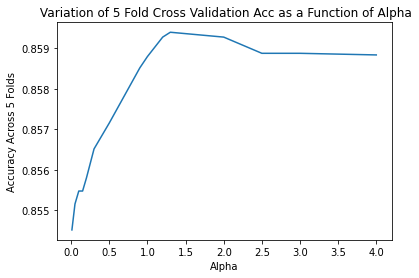

In [ ]:
plt.plot(alpha,scores)
# plt.plot(a,accuracyNB,label='MultinomialNB')
plt.xlabel('Alpha')
plt.ylabel('Accuracy Across 5 Folds')
plt.title(" Variation of 5 Fold Cross Validation Acc as a Function of Alpha") 
plt.show()

We see that a smoothing constant of 1.3 is the best

## Final NB Model using Best Parameters:

In [25]:
Nb = MultinomialNB(alpha=1.3)
start = time.time()
pred_train = Nb.fit(X_train,Y_train).predict(X_train)
pred_test = Nb.fit(X_train,Y_train).predict(X_test)
end = time.time()
print(" Train Accuracy using best alpha:", evaluate_acc(pred_train, Y_train))
print(" Test Accuracy using best alpha:", evaluate_acc(pred_test, Y_test))
print("Time for training (fitting and predicting on Test Set) :", end - start, "seconds")  

 Train Accuracy using best alpha: 0.88188
 Test Accuracy using best alpha: 0.83648
Time for training (fitting and predicting on Test Set) : 5.6609907150268555 seconds


# Logistic Regression:

## Logistic Regression on data without cleaning
The first pass is using the dataset as it is without any feature selection or prior cleaning and it is obvious it performs worse. We used a count vectorizer first.

In [34]:
clf = LogisticRegression(max_iter=2000)
count_vect = CountVectorizer()
start = time.time()
# fit the classifier
X_train_counts = count_vect.fit_transform(train_reviews)
X_test_counts = count_vect.transform(test_reviews)
# predict on training and get train score
Y_train_pred = clf.fit(X_train_counts,train_labels).predict(X_train_counts)
# predict on test and get test score
Y_test_pred = clf.fit(X_test_counts,train_labels).predict(X_test_counts)
end = time.time()
print("score on training data (uncleaned data):", evaluate_acc(Y_train_pred, train_labels))
print("score on test data (uncleaned data)", evaluate_acc(Y_test_pred, test_labels)) 
print("Time for training (fitting and predicting on Test Set) :", end - start, "seconds")

score on training data (uncleaned data): 0.99832
score on test data (uncleaned data) 0.50272
Time for training (fitting and predicting on Test Set) : 164.20261788368225 seconds


## Logistic Regression on cleaned data

Try a first pass fitting of the logistic regression

In [36]:
# Using linear regression for classification
start = time.time()
clf = LogisticRegression().fit(X_train, Y_train)
predicted = clf.predict(X_test)
end = time.time()
print('Train accuracy:' , evaluate_acc(Y_train,clf.predict(X_train)))
print('Test accuracy:' , evaluate_acc(Y_test,predicted))
print("Time for training (fitting and predicting on Test Set) :", end - start, "seconds")  

Train accuracy: 0.92656
Test accuracy: 0.87948
Time for training (fitting and predicting on Test Set) : 24.22335696220398 seconds


## Hyperparameter Tuning for Logistic Regression

In [ ]:
# create a list to keep the indices of the train and test tuples:
folds = []
# list comprehension to save the tuples
folds = [(tr, val) for (tr, val) in (cross_validation_split(np.array(X_train).shape[0], n_folds=5))]

We use the above method to create the folds, but we use the pipeline because of memory management. The cross validation is being done within the grid search using their cross validation. Look at the 20 news group to see the implementation of the custom cross validation method for hyperparameter tuning. 

In [ ]:
# hyperparameters tuning
text_clf = Pipeline([
     ('tfidf_vect', TfidfVectorizer(stop_words='english',max_features = 10000)),
     ('clf', LogisticRegression(max_iter=500)),
 ])
parameters = {
     'clf__C': (100, 10, 1.0, 0.1, 0.01),
     'clf__penalty': ('l2', 'l1'),
     'clf__solver':('lbfgs', 'liblinear')
 }

# define grid search
gs_clf = GridSearchCV(text_clf, parameters,scoring = "accuracy", cv=5)
gs_clf = gs_clf.fit(np.array(train_reviews_clean), Y_train)

print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

0.8855999999999999
clf__C: 1.0
clf__penalty: 'l2'
clf__solver: 'liblinear'


## Final Logistic Regression Model using Best Parameters:

In [37]:
# Calculate the performance of LR model on the test dataset using the best hyperparameter: penalty='l2',C=4
start = time.time()
clf = LogisticRegression(penalty='l2',C=1 , max_iter=500,solver='liblinear').fit(X_train, Y_train)
predicted = clf.predict(X_test)
end = time.time()
print('Train accuracy:' , evaluate_acc(Y_train,clf.predict(X_train)))
print('Test accuracy:' , evaluate_acc(Y_test,predicted))
print("Time for training (fitting and predicting on Test Set) :", end - start, "seconds")
# Confusion matrix
cm = confusion_matrix(Y_test, predicted)
print(metrics.classification_report(Y_test, predicted))

Train accuracy: 0.92656
Test accuracy: 0.87948
Time for training (fitting and predicting on Test Set) : 2.5704686641693115 seconds
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



# Testing for different training set sizes:

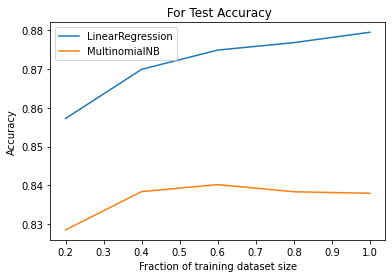

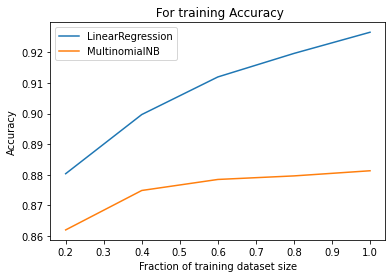

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# Ploting the accuracy vs. training dataset size for NB and LR models
n=X_train.shape[0]
a = [0.2, 0.4, 0.6, 0.8, 1]
accuracyNB_test = []
accuracyLR_test = []
accuracyNB_train = []
accuracyLR_train = []
# loop over fractions
for i in a:
    # naive bayes
    clf1 = MultinomialNB(alpha=2).fit(X_train[:int(i*n)], Y_train[:int(i*n)])
    accuracyNB_train.append(evaluate_acc(Y_train,clf1.predict(X_train)))
    accuracyNB_test.append (evaluate_acc(Y_test,clf1.predict(X_test)))

    # logistic regression
    clf2 = LogisticRegression(max_iter=500, solver='liblinear', C = 1, penalty='l2').fit(X_train[:int(i*n)], Y_train[:int(i*n)])
    accuracyLR_train.append(evaluate_acc(Y_train,clf2.predict(X_train)))
    accuracyLR_test.append (evaluate_acc(Y_test,clf2.predict(X_test)))

# plot test results
plt.plot(a,accuracyLR_test,label='LinearRegression')
plt.plot(a,accuracyNB_test,label='MultinomialNB')
plt.xlabel('Fraction of training dataset size')
plt.ylabel('Accuracy')
plt.title(" For Test Accuracy")
plt.legend() 
plt.show()
plt.figure()

# plot training results
plt.plot(a,accuracyLR_train,label='LinearRegression')
plt.plot(a,accuracyNB_train,label='MultinomialNB')
plt.xlabel('Fraction of training dataset size')
plt.ylabel('Accuracy')
plt.title(" For training Accuracy")
plt.legend() 
plt.show()
plt.figure()

# Training Using SGDC Classifier:
SVMs are some of the best NLP tools out there, especially the ones with linear kernels. Hence, I thought I would try it here:

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
# SGDC acts as a SVM when loss equals 'hinge'
text_clf = Pipeline([
       ('tfidf', TfidfVectorizer(stop_words='english', min_df=3)),
       ('clf', SGDClassifier(loss='hinge', penalty='l2',
       alpha=1e-3, random_state=42,
        max_iter=5, tol=None)), ])
start = time.time()
train_predicted = text_clf.fit(train_reviews_clean, Y_train).predict(train_reviews_clean)
test_predicted = text_clf.fit(train_reviews_clean, Y_train).predict(test_reviews_clean)
end = time.time()
print(" Training Accuracy:", evaluate_acc(train_predicted, Y_train))
print(" Testing Accuracy:", evaluate_acc(test_predicted, Y_test))
print(" Time when using SVM:", end - start)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, test_predicted)

from sklearn import metrics
print("Metrics per class:")
print(metrics.classification_report(Y_test, test_predicted))

 Training Accuracy: 0.86092
 Testing Accuracy: 0.84264
 Time when using SVM: 16.689595460891724
Metrics per class:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     12500
           1       0.80      0.91      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



# Testing Using a Binary Decision Tree:
We chose to build a decision tree classifier because it showed its potential in the previous miniassignment. We here compare it against the other 3 classifiers

In [ ]:
# We calculate the performance of DecisionTreeClassifier model on the test dataset
from sklearn.tree import DecisionTreeClassifier
start= time.time()
clf = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
predicted = clf.predict(X_test)
end=time.time()
print('Train accuracy:' , evaluate_acc(Y_train,clf.predict(X_train)))
print('Test accuracy:' , evaluate_acc(Y_test,predicted))
print("Time for training and testing:", end - start, "seconds")
cm = confusion_matrix(Y_test, predicted)
print(metrics.classification_report(Y_test, predicted))

Train accuracy: 1.0
Test accuracy: 0.71628
Time for training and testing: 154.43828463554382 seconds
              precision    recall  f1-score   support

           0       0.71      0.72      0.72     12500
           1       0.72      0.71      0.71     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



# Testing Ada boost

In [ ]:
# Fitting Ada boost classifier to the Training set
from sklearn.ensemble import AdaBoostClassifier
# Training Ada boost classifier
end=time.time()
clf = AdaBoostClassifier().fit(X_train, Y_train) 
predicted = clf.predict(X_test)
end=time.time()

print('Train accuracy:' , evaluate_acc(Y_train,clf.predict(X_train)))
print('Test accuracy:' , evaluate_acc(Y_test,predicted))
print("Time for training and testing:", end - start, "seconds")

cm = confusion_matrix(Y_test, predicted)
print(metrics.classification_report(Y_test, predicted))

Train accuracy: 0.80672
Test accuracy: 0.8016
Time for training and testing: 804.1681017875671 seconds
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     12500
           1       0.78      0.85      0.81     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000

